# Efficiency

Evaluate the efficiency as the average over the bin, excluding a 2 deg GC mask. This is done using the digitized version of Figure 7 in [1705.00009](https://arxiv.org/pdf/1705.00009.pdf). This implies we have no longitude dependence in our efficiency or information regarding the truth versus reconstructed flux dependence.

We have $12\times12$ spatial bins in the $40\times40$ region, with our bins starting on the top left of the map $(\ell,b)=(20,20)$ and moving to the bottom right $(\ell,b)=(-20,-20)$.

All fluxes are in MeV$\,$cm$^{-2}$$\,$s and angles in degrees.

**NB:** The integration step below takes some time to run, to skip this and just look at the file, move to the plotting step below.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.integrate import quad
import matplotlib
matplotlib.matplotlib_fname()
import matplotlib.pyplot as plt

In [2]:
# Load the efficiency as specified by Mattia
fluxvals = np.array([5.01187234e-07, 7.94328235e-07, 1.25892541e-06,
                    1.99526231e-06, 3.16227766e-06, 5.01187234e-06,
                    7.94328235e-06, 1.25892541e-05, 1.99526231e-05,
                    3.16227766e-05, 5.01187234e-05, 7.94328235e-05,
                    1.25892541e-04, 1.99526231e-04])
bvals = np.array([1., 3., 5., 7.5, 10.5, 14., 18.])

efficiency = np.zeros((len(fluxvals),len(bvals)))

efficiency[:, 0] = [0.00354610, 0.00411523, 0.01162791, 0.00854701, 0.05857741,
                    0.17112299, 0.22916667, 0.28140704, 0.32989691, 0.42405063,
                    0.46601942, 0.60000000, 0.80000000, 1.00000000]
efficiency[:, 1] = [0.00892857, 0.01785714, 0.06493506, 0.15789474, 0.30909091,
                    0.40816327, 0.62162162, 0.76595745, 0.70833333, 0.81159420,
                    0.88636364, 0.90000000, 0.94339623, 1.00000000]
efficiency[:, 2] = [0.01190476, 0.01086957, 0.11627907, 0.38095238, 0.69411765,
                    0.83950617, 0.87671233, 0.90647059, 0.91769231, 0.92444444,
                    0.95444444, 0.97444444, 1.00000000, 1.00000000]
efficiency[:, 3] = [0.00000000, 0.04166667, 0.14782609, 0.39622642, 0.71739130,
                    0.74712644, 0.89189189, 0.85915493, 0.85365854, 0.90058824,
                    0.92647059, 0.95476190, 1.00000000, 1.00000000]
efficiency[:, 4] = [0.00925926, 0.06603774, 0.20408163, 0.50980392, 0.85294118,
                    0.84615385, 0.88505747, 0.92222222, 0.94366197, 0.95522388,
                    0.94339623, 0.95000000, 1.00000000, 1.00000000]
efficiency[:, 5] = [0.00000000, 0.05590062, 0.19298246, 0.52307692, 0.79032258,
                    0.85600000, 0.85964912, 0.90740741, 0.90774194, 0.89156627,
                    0.92461538, 0.89500000, 1.00000000, 1.00000000]
efficiency[:, 6] = [0.02142857, 0.05263158, 0.20833333, 0.55905512, 0.71052632,
                    0.76237624, 0.80357143, 0.87878788, 0.92391304, 0.95555556,
                    0.93750000, 0.95000000, 1.00000000, 1.00000000]

Convert the efficiency to our flux values. Use 6 flux bins from $10^{-6}$ to $10^{-5}$ MeV$\,$cm$^{-2}$$\,$s and additionally 2 from $10^{-5}$ to $10^{-4}$ MeV$\,$cm$^{-2}$$\,$s as _Fermi_ does.

In [3]:
# 6 flux bins from 1e-6 to 1e-5 and 2 from 1e-5 to 1e-4, evaluate midpoints below
fluxvals1 = 10**(1./12.+np.linspace(-6,-5,7)[:6])
fluxvals2 = 10**(0.25+np.linspace(-5,-4,3)[:2])
our_fluxvals = np.append(fluxvals1,fluxvals2)

# Now convert efficiency to be at our fluxes, but original b values
efficiency_ourflux = np.zeros((len(bvals),len(our_fluxvals)))

for i in range(len(bvals)):
    for j in range(len(our_fluxvals)):
        efficiency_ourflux[i,j] = np.interp(our_fluxvals[j], fluxvals, efficiency[:,i])

Get the efficiency by integrating over the bins, excluding 2$^\circ$ circular GC mask.

In [6]:
# Define bin edges for integrals - go top left to bottom right
ang_edges = np.linspace(20.,-20.,13,dtype=np.float)

# Define step function used for the mask
def step(x):
    return 1 * (x > 0)

# Calculate 12x12x8 efficiency (l, b, flux)
our_efficiency = np.zeros((12,12,8))
for i in tqdm_notebook(range(12)):
    for j in range(12):
        # Determine the solid angle of this bin
        dOmega = np.abs(quad(lambda l: quad(lambda b: np.cos(b*np.pi/180.)*step(180./np.pi*np.arccos(np.cos(l*np.pi/180.)*np.cos(b*np.pi/180.))-2.),ang_edges[j], ang_edges[j+1])[0], ang_edges[i],ang_edges[i+1])[0])

        for k in range(8):
            # Efficiency is integral over bin divided by the solid angle
            # Account for fact efficiency above only defined for positive b
            our_efficiency[i,j,k] = np.abs(quad(lambda l: quad(lambda b: np.cos(b*np.pi/180.)*step(180./np.pi*np.arccos(np.cos(l*np.pi/180.)*np.cos(b*np.pi/180.))- 2.)*np.interp(np.abs(b), bvals, efficiency_ourflux[:,k]),ang_edges[j],ang_edges[j+1])[0],ang_edges[i],ang_edges[i+1])[0])/dOmega

In [ ]:
# Save the efficiency 
np.save('../data/omega_ijk_int.npy', our_efficiency)

## Plot efficiency

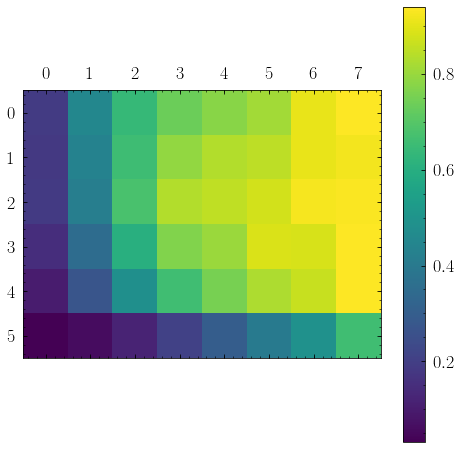

In [5]:
# Plot the efficiency function with respect to latitude (y-axis) and flux (x-axis)
our_efficiency = np.load('../likelihood/data/omega_ijk_int.npy')
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(np.average(our_efficiency,axis=0)[0:6,:], interpolation='nearest')
fig.colorbar(cax)
plt.show()